# Object detection and ROI feature extraction

In [6]:
# Python
import os
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.ops import roi_align
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [7]:
gtea_dir = "/data/Datasets/EASG/gtea"
png_dir = os.path.join(gtea_dir, "png")
slowfast_dir = os.path.join(gtea_dir, "slowfast")
roi_dir = os.path.join(gtea_dir, "roi_align")

In [8]:
# Load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

with open('coco-labels.txt') as f:
    categories = [l.strip() for l in f.readlines()]


/home/muyang/miniconda3/envs/ilp/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/muyang/miniconda3/envs/ilp/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
# Function to load an image and convert it to a tensor
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = torchvision.transforms.ToTensor()(image)
    return image

def fasterrcnn_predict(image, model, score_threshold=0):
    with torch.no_grad():
        predictions = model([image])

    boxes, labels, scores = predictions[0].values()
    mask = scores >= score_threshold
    return boxes[mask], labels[mask], scores[mask]

# Function to extract ROIAlign features
def extract_roialign_features(image, model, boxes):
    rois = torch.cat([torch.zeros((boxes.shape[0], 1)), boxes], dim=1)
    with torch.no_grad():
        # Get the features from the backbone
        features = model.backbone(image.unsqueeze(0))
        
        # Use the ROIAlign layer to extract features from the ROIs
        aligned_features = roi_align(features['0'], rois, output_size=(7, 7), aligned=True)
        print((aligned_features[2]-aligned_features[1]).sum())
        
        return aligned_features

# image should be [C, H, W]
def visualize_bbs(image, boxes, labels, scores, categories):
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.axis('off')  # Hide axes

    # Assuming `boxes` is a tensor of shape [num_boxes, 4] and `labels` is a list of labels
    for box, label, score in zip(boxes, labels, scores):
        label = categories[label-1]
        x, y, x2, y2 = box
        width = x2 - x
        height = y2 - y
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        caption = f'{label}:{(score*100):.0f}'
        plt.text(x, y, caption, color='white', fontsize=10, bbox=dict(facecolor='red', alpha=0.5))
    plt.show()

In [37]:
def process_frame(model, png_dir, video_name, frame):
    if type(frame) == int:
        image_path = os.path.join(png_dir, video_name, f'{(frame+1):010d}.png')
        print(image_path)
    else:
        image_path = os.path.join(png_dir, video_name, frame)
    image = load_image(image_path)
    boxes, labels, scores = fasterrcnn_predict(image, model, score_threshold=0.5)
    features = extract_roialign_features(image, model, boxes)
    
    N = features.shape[0]
    features = model.roi_heads.box_head(features.reshape(N, -1))
    return image, boxes, labels, scores, features

def process_video(model, png_dir, video_name, save_dir=None, sample_rate=1):
    frames_dir = os.path.join(png_dir, video_name)
    video_features = []
    frames = sorted(os.listdir(frames_dir))[::sample_rate]
    print(len(frames))
    for frame in frames:
        _,_,_,_, features = process_frame(model, png_dir, video_name, frame)
        print(features.shape)
        video_features.append(features)

    #video_features = torch.vstack(video_features, dim=1)
    if save_dir:
        save_path = os.path.join(save_dir, f'{video_name}_roi_align.pt')
        torch.save(video_features, save_path)
        #np.save(save_path, video_features.cpu().numpy())
    return video_features

def process_dir(model, png_dir):
    for video_name in os.listdir(png_dir):
        process_video(model, png_dir, video_name)

### Single frame

/data/Datasets/EASG/gtea/png/S1_Cheese_C1/0000000001.png
tensor(0.)


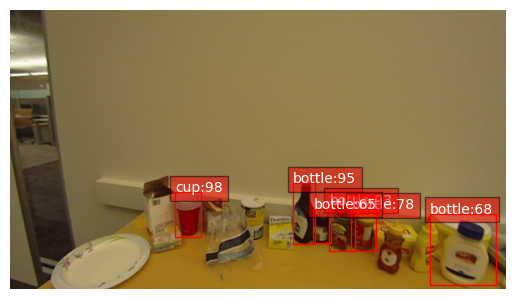

In [38]:
video_name = "S1_Cheese_C1"
image, boxes, labels, scores, features = process_frame(model, png_dir, video_name, 0)

visualize_bbs(image, boxes, labels, scores, categories) 

In [39]:
import torch
from torchvision.ops import roi_align

# Example input tensor (batch size 1, channels 256, height 14, width 14)
input_tensor = torch.randn(1, 256, 14, 14)

# Define bounding boxes (batch index, x1, y1, x2, y2)
boxes = torch.tensor([[0, 1, 1, 5, 5], [0, 6, 6, 10, 10]]).float()

# Apply ROI Align
output = roi_align(input_tensor, boxes, output_size=(7, 7))

print(output.shape)  # Should be (N_boxes, C, output_size[0], output_size[1])
print((output[0]-output[1]).sum())

torch.Size([2, 256, 7, 7])
tensor(17.5544)


### Process videos

In [40]:
for video_name in os.listdir(png_dir):
    video_features = process_video(model, png_dir, video_name, roi_dir, sample_rate=100)

10


tensor(0.)
torch.Size([5, 1024])
tensor(0.)
torch.Size([8, 1024])
tensor(0.)
torch.Size([11, 1024])
tensor(0.)
torch.Size([14, 1024])
tensor(0.)
torch.Size([12, 1024])
tensor(0.)
torch.Size([11, 1024])
tensor(0.)
torch.Size([10, 1024])
tensor(0.)
torch.Size([12, 1024])
tensor(0.)
torch.Size([9, 1024])
tensor(0.)
torch.Size([11, 1024])
10
tensor(0.)
torch.Size([8, 1024])
tensor(0.)
torch.Size([17, 1024])
tensor(0.)
torch.Size([14, 1024])
tensor(0.)
torch.Size([14, 1024])
tensor(0.)
torch.Size([11, 1024])
tensor(34.8242)
torch.Size([13, 1024])
tensor(0.)
torch.Size([16, 1024])
tensor(-20.9258)
torch.Size([9, 1024])
tensor(-159.9317)
torch.Size([10, 1024])
tensor(0.)
torch.Size([17, 1024])
14
tensor(0.)
torch.Size([8, 1024])
tensor(0.)
torch.Size([11, 1024])
tensor(0.)
torch.Size([7, 1024])
tensor(0.)
torch.Size([13, 1024])
tensor(31.0117)
torch.Size([11, 1024])
tensor(38.0109)
torch.Size([12, 1024])
tensor(0.)
torch.Size([17, 1024])
tensor(40.4501)
torch.Size([16, 1024])
tensor(0.)
torch

IndexError: index 2 is out of bounds for dimension 0 with size 2

## EASG test on GTEA

In [39]:
from pathlib import Path
from run_easg import EASG

path_to_annotations = Path('/data/Datasets/EASG/EASG/generation/annts_in_new_format')
path_to_data = Path("/data/Datasets/EASG/EASG/generation/data")

#load vocab
with open(path_to_annotations / 'verbs.txt') as f:
    verbs = [l.strip() for l in f.readlines()]

with open(path_to_annotations / 'objects.txt') as f:
    objs = [l.strip() for l in f.readlines()]

with open(path_to_annotations / 'relationships.txt') as f:
    rels = [l.strip() for l in f.readlines()]

easg_model = EASG(verbs, objs, rels)
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
easg_model.load_state_dict(torch.load('output/checkpoint91.pt', map_location=device))
easg_model.to(device)
easg_model.eval()

EASG(
  (fc_verb): Linear(in_features=2304, out_features=198, bias=True)
  (fc_objs): Linear(in_features=1024, out_features=391, bias=True)
  (fc_rels): Linear(in_features=3328, out_features=13, bias=True)
)

In [68]:
def get_verb_obj_rel(model, clip_feat, obj_feats):

    print(clip_feat.shape, obj_feats.shape)     
    print(clip_feat.cpu(), obj_feats.cpu())

    clip_feat = clip_feat.unsqueeze(0).to(device)
    obj_feats = obj_feats.to(device)

    out_verb, out_objs, out_rels = model(clip_feat, obj_feats)

    pred = [verbs[torch.argmax(out_verb, dim=1)], \
            [objs[torch.argmax(out_objs, dim=1)[i]] for i in range(len(out_objs))], \
            [rels[torch.argmax(out_rels, dim=1)[i]] for i in range(len(out_rels))] ]

    return pred

In [83]:
import networkx as nx

def visualize_easg(parent, children, relationships):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes
    G.add_node(parent)
    for child in children:
        print(child)
        G.add_node(child)

    # Add edges with relationships
    for i, child in enumerate(children):
        G.add_edge(parent, child, label=relationships[i])

    # Define layout
    pos = nx.spring_layout(G)

    # Draw nodes and edges
    nx.draw(G, pos, with_labels=True, node_size=5000, node_color='lightblue', font_weight='bold', arrowsize=20)
    
    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15)

    plt.title('Directed Graph Visualization')
    plt.show()

/data/Datasets/EASG/gtea/png/S3_Peanut_C1/0000000501.png
torch.Size([2304]) torch.Size([11, 1024])
tensor([0.1016, 0.0481, 0.1684,  ..., 0.0407, 0.0000, 0.0024]) tensor([[0.0054, 0.0293, 0.0664,  ..., 0.0000, 0.0586, 0.0319],
        [0.0054, 0.0293, 0.0664,  ..., 0.0000, 0.0586, 0.0319],
        [0.0054, 0.0293, 0.0664,  ..., 0.0000, 0.0586, 0.0319],
        ...,
        [0.0054, 0.0293, 0.0664,  ..., 0.0000, 0.0586, 0.0319],
        [0.0054, 0.0293, 0.0664,  ..., 0.0000, 0.0586, 0.0319],
        [0.0000, 0.4259, 0.3325,  ..., 0.0000, 0.3100, 0.2661]],
       requires_grad=True)
['close', ['right_hand', 'right_hand', 'right_hand', 'right_hand', 'right_hand', 'right_hand', 'right_hand', 'right_hand', 'right_hand', 'right_hand', 'right_hand'], ['dobj', 'dobj', 'dobj', 'dobj', 'dobj', 'dobj', 'dobj', 'dobj', 'dobj', 'dobj', 'dobj']]


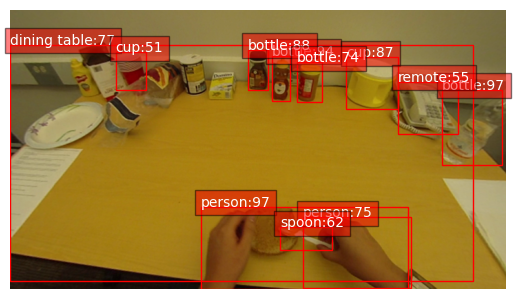

right_hand0
right_hand1
right_hand2
right_hand3
right_hand4
right_hand5
right_hand6
right_hand7
right_hand8
right_hand9
right_hand10


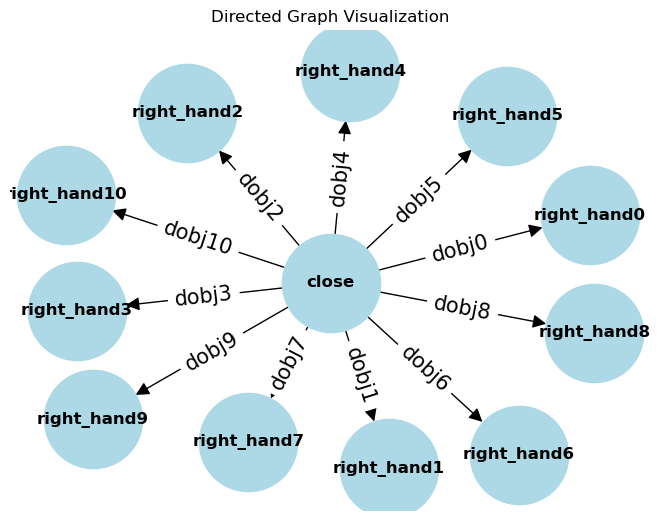

In [84]:
#video_name = "S1_Cheese_C1"
video_name = "S3_Peanut_C1"
frame_idx = 500

image, boxes, labels, scores, features = process_frame(png_dir, video_name, frame_idx)

slowfast = torch.Tensor(np.load(os.path.join(slowfast_dir, f"{video_name}_slowfast_features.npy")))
roi = torch.load(os.path.join(roi_dir, f"{video_name}_roi_align.pt"))

pred = get_verb_obj_rel(easg_model, slowfast, roi[frame_idx//100])
print(pred)

visualize_bbs(image, boxes, labels, scores, categories)

parent = pred[0]
children = pred[1]
relationships = pred[2]

children = [f"{child}{i}" for i,child in enumerate(children)]
relationships = [f"{rel}{i}" for i,rel in enumerate(relationships)]

visualize_easg(parent, children, relationships)